Here we want to correlation ERCC concentration with log counts

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import linregress
import glob
%load_ext rpy2.ipython

In [2]:
fig_dir = "/ifs/projects/toms/umi_paper/GSE65525/figures.dir/"
ercc_conc_inf = "../data/cms_095046.txt"

In [3]:
expression_infs = [os.path.join(fig_dir, "dedup_unique_SRR1784317_merged_gene_counts.tsv"),
                   os.path.join(fig_dir, "dedup_directional_SRR1784317_merged_gene_counts.tsv"),
                   os.path.join(fig_dir, "transcriptome_SRR1784317_merged_gene_counts.tsv")]


In [4]:
ercc_conc_df = pd.read_table(ercc_conc_inf, sep="\t")
print ercc_conc_df.head()
print ercc_conc_df.columns

   Re-sort ID     ERCC ID subgroup  concentration in Mix 1 (attomoles/ul)  \
0           1  ERCC-00130        A                               30000.00   
1           2  ERCC-00004        A                                7500.00   
2           3  ERCC-00136        A                                1875.00   
3           4  ERCC-00108        A                                 937.50   
4           5  ERCC-00116        A                                 468.75   

   concentration in Mix 2 (attomoles/ul)  expected fold-change ratio  \
0                              7500.0000                         4.0   
1                              1875.0000                         4.0   
2                               468.7500                         4.0   
3                               234.3750                         4.0   
4                               117.1875                         4.0   

   log2(Mix 1/Mix 2)  
0                2.0  
1                2.0  
2                2.0  
3           

In [5]:
norm_final_df = pd.DataFrame()

def norm_counts(array):
    sum_array = sum(array)
    return [float(x)/sum_array for x in array]

for inf in expression_infs:
    method = os.path.basename(inf.replace("transcriptome", "dedup_transcriptome")).split("_")[1]
    expression_df = pd.read_table(inf, sep="\t", index_col=0)

    expression_df_norm = expression_df.apply(func=norm_counts, axis=0)
    expression_df_norm_summary = expression_df_norm.ix[ercc_conc_df['ERCC ID']]
    expression_df_norm_summary['mean'] = expression_df_norm_summary.mean(axis=1)
    expression_df_norm_summary['stderr'] = (expression_df_norm_summary.std(axis=1) /
                                            np.sqrt(len(expression_df_norm_summary.columns)))
    expression_df_norm_summary.drop([x for x in expression_df_norm_summary.columns if x not in
                                     ["mean", "stderr"] ], axis=1, inplace=True)
    
    expression_df_norm_summary = pd.merge(expression_df_norm_summary, ercc_conc_df, 
                                          left_index=True, right_on="ERCC ID")
    expression_df_norm_summary['method'] = method

    norm_final_df = pd.concat([norm_final_df, expression_df_norm_summary])
    print norm_final_df.shape
    
print norm_final_df.head()

(92, 10)
(184, 10)
(276, 10)
       mean    stderr  Re-sort ID     ERCC ID subgroup  \
0  0.034041  0.000176           1  ERCC-00130        A   
1  0.015627  0.000095           2  ERCC-00004        A   
2  0.003875  0.000045           3  ERCC-00136        A   
3  0.002063  0.000032           4  ERCC-00108        A   
4  0.000417  0.000014           5  ERCC-00116        A   

   concentration in Mix 1 (attomoles/ul)  \
0                               30000.00   
1                                7500.00   
2                                1875.00   
3                                 937.50   
4                                 468.75   

   concentration in Mix 2 (attomoles/ul)  expected fold-change ratio  \
0                              7500.0000                         4.0   
1                              1875.0000                         4.0   
2                               468.7500                         4.0   
3                               234.3750                         4.0 

          mean       stderr Re.sort.ID    ERCC.ID subgroup
1 0.0340414843 1.758722e-04          1 ERCC-00130        A
2 0.0156270443 9.459068e-05          2 ERCC-00004        A
3 0.0038752269 4.488264e-05          3 ERCC-00136        A
4 0.0020626793 3.169905e-05          4 ERCC-00108        A
5 0.0004165961 1.356299e-05          5 ERCC-00116        A
6 0.0007661584 1.963785e-05          6 ERCC-00092        A
  concentration.in.Mix.1..attomoles.ul. concentration.in.Mix.2..attomoles.ul.
1                             30000.000                            7500.00000
2                              7500.000                            1875.00000
3                              1875.000                             468.75000
4                               937.500                             234.37500
5                               468.750                             117.18750
6                               234.375                              58.59375
  expected.fold.change.ratio log2.Mix.1.M

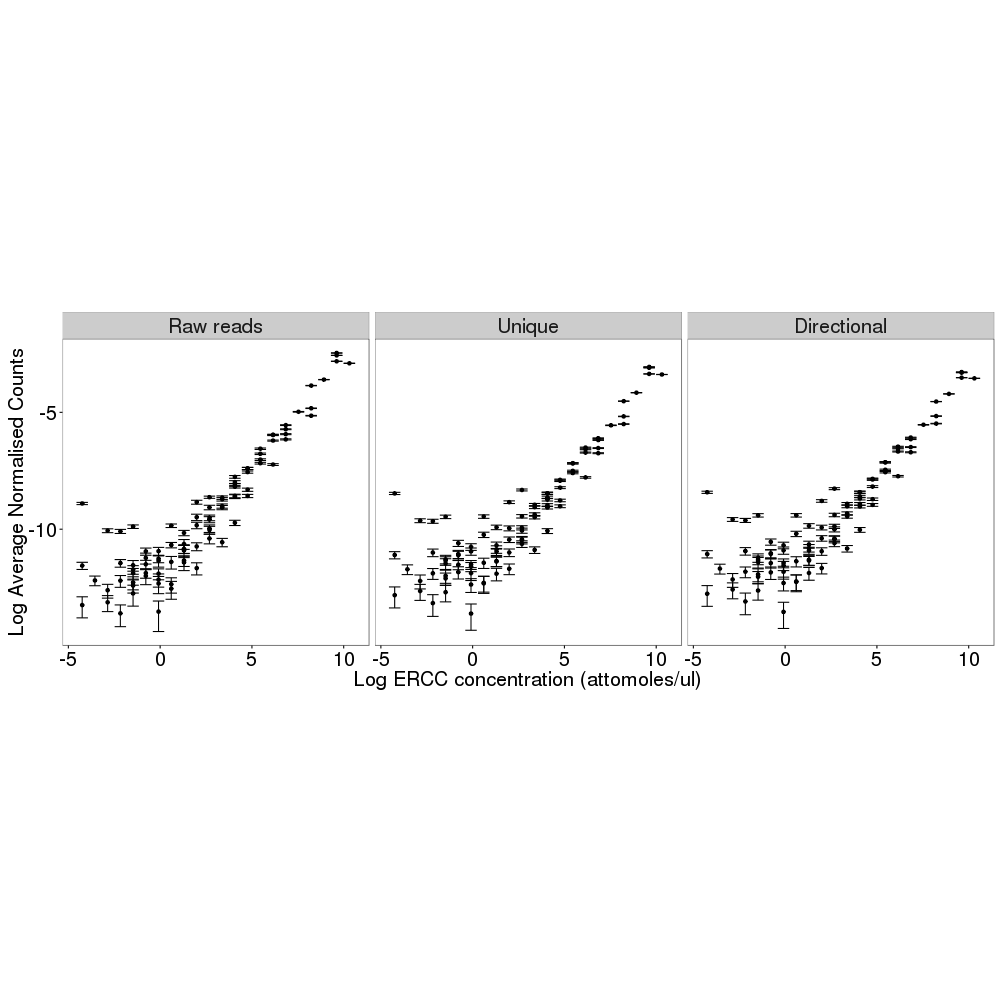

In [6]:
%%R -i norm_final_df -w 1000 -h 1000


library(ggplot2)
library(plyr)

norm_final_df$method = factor(norm_final_df$method, levels=c("transcriptome", "unique", "directional"))

norm_final_df$method = revalue(norm_final_df$method,c(
    "transcriptome" = "Raw reads", "directional" = "Directional", "unique" = "Unique"))
m_txt = element_text(size=20)
s_txt = element_text(size=15)

t = theme_bw() + 
    theme(axis.text = m_txt,
          axis.title = m_txt,
          legend.title = m_txt,
          legend.text = m_txt,
          legend.key = element_blank(),
          legend.key.width=unit(1,"cm"),
          legend.key.height=unit(0.7,"cm"),
          aspect.ratio=1,
          panel.grid=element_blank(),
          strip.text = m_txt)

print(head(norm_final_df))

p = ggplot(norm_final_df,
           aes(y=log(mean), x=log(concentration.in.Mix.1..attomoles.ul.))) +
geom_point() +
geom_errorbar(aes(ymin = log(mean - stderr), ymax = log(mean + stderr))) +
facet_wrap(~method) + theme_bw() + t +
xlab("Log ERCC concentration (attomoles/ul)") +
ylab("Log Average Normalised Counts") #+ geom_abline(slope=1, intercept=-13)

ggsave("../figures.dir/corr_average.png", width=12, height=8)
print(p)

In [7]:
def pearsonLog(df, xcol, ycol):
    df = df[df[xcol]>6]
    #df = df[df[ycol]>0]
    return df[[xcol, ycol]].corr(method="pearson").iloc[0,1]

In [8]:
final_df_corr = pd.DataFrame()

for inf in expression_infs:
    method = os.path.basename(inf.replace("transcriptome", "dedup_transcriptome")).split("_")[1]
    expression_df = pd.read_table(inf, sep="\t", index_col=0)

    ercc_expression_df = expression_df.ix[ercc_conc_df['ERCC ID']]
    ercc_expression_df = pd.melt(ercc_expression_df.reset_index(), id_vars="gene")
    merged_ercc_expression_df = pd.merge(ercc_expression_df, ercc_conc_df, left_on="gene", right_on="ERCC ID")

    merged_ercc_expression_df = merged_ercc_expression_df[
        merged_ercc_expression_df["concentration in Mix 1 (attomoles/ul)"].astype(float)>1]

    corr_df = pd.DataFrame(merged_ercc_expression_df.groupby("variable").apply(
        pearsonLog, ycol="value", xcol="concentration in Mix 1 (attomoles/ul)"))

    corr_df.columns = ["corr"]
    corr_df['method'] = method
    
    final_df_corr = pd.concat([final_df_corr, corr_df])

final_df_corr.reset_index(inplace=True)

print final_df_corr.head()



            variable      corr  method
0  AAAACCTCCACGAAACG  0.886379  unique
1  AAAACGCCTTCCCAATC  0.932103  unique
2  AAAAGCCTAAGGTTGTG  0.884531  unique
3  AAAAGTCGGAAGGTAAT  0.926074  unique
4  AAAAGTCGGACTTCAAT  0.896839  unique


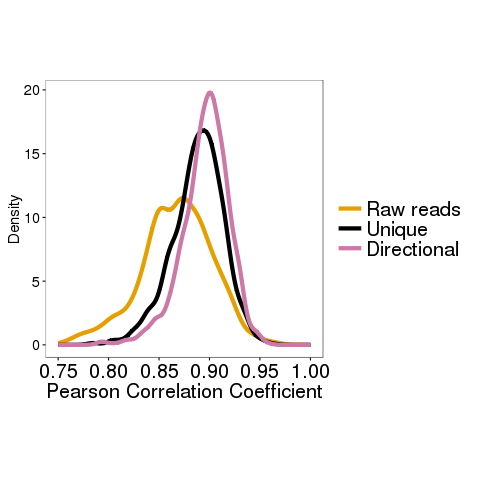

In [9]:
%%R -i final_df_corr 

library(ggplot2)
library(plyr)

gg_color_hue <- function(n) {
 colours = c("black", "grey70", "#F0E442", "#009E73", "#CC79A7",
          "#E69F00", "#0072B2", "#D55E00")
return(colours[1:n])}

final_df_corr$method = factor(final_df_corr$method, levels=c("transcriptome", "unique", "directional"))

final_df_corr$method = revalue(final_df_corr$method,c(
    "transcriptome" = "Raw reads", "directional" = "Directional", "unique" = "Unique"))


m_txt = element_text(size=20)
s_txt = element_text(size=15)

t = theme_bw() + 
    theme(axis.text.x = m_txt,
          axis.title.x = m_txt,
          axis.text.y = s_txt,
          axis.title.y = s_txt,
          legend.title = m_txt,
          legend.text = m_txt,
          legend.key = element_blank(),
          legend.key.width=unit(1,"cm"),
          legend.key.height=unit(0.7,"cm"),
          aspect.ratio=1,
          panel.grid=element_blank())

p = ggplot(final_df_corr, aes(corr, colour=method)) +
stat_density(geom="line",position="identity", size=2) +
#geom_density(show_guide=FALSE, size=2) +
t +
scale_colour_manual(name="", values=c(gg_color_hue(7)[c(6,1,5)])) +
xlab("Pearson Correlation Coefficient") + ylab("Density") +
scale_x_continuous(limits=c(0.75,1)) +
guides(colour = guide_legend(override.aes = list(size = 2)))
ggsave("../figures.dir/corr_density.png", width=9, height=6)
print(p)